# Разработка решений для персонализации предложений постоянным клиентам магазина "В один клик"

## Введение

<font color='white'><b><u>Целевая задача Заказчика</b></u><i> - удерживать активность постоянных клиентов с помощью персонализированных предложений</i><br>

<Font color='white'><b><i><u>Цель исследования </b></i></u>- разработка рекомендаций для интернет-магазина "В один клик", которые позволят персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность

<Font color='white'><b><i><u>План работы</b></i></u><br>1. загрузка, обзор и предобработка данных<br>&nbsp;&nbsp;&nbsp;- загрузка библиотек<br>&nbsp;&nbsp;&nbsp;- загрузка и обзор данных<br>&nbsp;&nbsp;&nbsp;- предобработка данных<br>
<Font color='white'>2. анализ данных<br>&nbsp;&nbsp;&nbsp;- анализ данных поведении покупателей, о выручке и прибыли магазина <br>&nbsp;&nbsp;&nbsp;- анализ объединенных данных в рарезе покупательской активности<br>&nbsp;&nbsp;&nbsp;- корреляционный анализ данных <br>
<Font color='white'>3. выбор наилучшей модели пронозирования снижения покупательской активности<br>


## Загрузка и обзор днных

### Загрузка библиотек

In [87]:
# импорт основных библиотек
import pandas as pd
import os
import numpy as np
#!pip install shap
import shap
#!pip install phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# импорт модулей для разделения данных и создания моделей МО
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split

# загружаем необходимые инструменты для создания пайплайна
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# импорт модулей для масштабирования и кодирования
from sklearn.preprocessing import (LabelEncoder,
                                   OneHotEncoder,
                                   OrdinalEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler,
                                   RobustScaler)
 
# загружаем инструмент для автоподбора гиперпараметров
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# импорт модулей для расчета метрик
from sklearn.metrics import (mean_absolute_error, \
                            r2_score, \
                            mean_squared_error, \
                            recall_score,\
                            precision_score, \
                            accuracy_score, \
                            roc_auc_score, \
                            confusion_matrix)

# импорт библиотек для визуализации
from matplotlib import pyplot as plt
#pip install seaborn
import seaborn as sns

# Снимем ограничения на вывод данных в pandas-таблице
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

#выделение заголовков таблиц
styles = [dict(selector="caption",
            props=[("text-align", "center"),
                   ("font-weight", "bold"),
                   ("font-size", "120%"),
                   ("color", 'black')])]

### Загрузка и обзор данных

In [88]:
# функция для обзора данных
def display_df_info(data):
    display(data.head(5))
    print('-'*100)
    data.info()
    print('-'*100)
    print('Количество столбцов - {}, количество записей - {}'.format(data.shape[1], data.shape[0]))
   
    dupl = data.duplicated().sum()
    if dupl != 0:
        print('Выявлено {:,.0f} дубликатов записей, их количество составляет {:.2%} от всех записей'.format(dupl, dupl / data.shape[0]))
    else:
        print('Дубликаты записей не выявлены')

In [89]:
# загрузим предоставленные датасеты
path_global = os.getcwd()
## 1.данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении
pth1 = path_global + '\\market_file.csv' 
## 2. данные о выручке, которую получает магазин с покупателя
pth2 = path_global + '\\market_money.csv'
## 3. данные о времени (в минутах), которое покупатель провёл на сайте в течение периода
pth3 = path_global + '\\market_time.csv'
## 4. данные о среднемесячной прибыли покупателя за последние 3 месяца
pth4 = path_global + '\\money.csv'

if os.path.exists(pth1):
    market_file = pd.read_csv(pth1)
else:
    print('Something is wrong with pth1')
if os.path.exists(pth2):
    market_money = pd.read_csv(pth2)
else:
    print('Something is wrong  with pth2')
if os.path.exists(pth3):
    market_time = pd.read_csv(pth3)
else:
    print('Something is wrong  with pth3')
if os.path.exists(pth4):
    money = pd.read_csv(pth4, sep=';')
else:
    print('Something is wrong  with pth4')


In [90]:
display_df_info(market_file)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  


In [91]:
display_df_info(market_money)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,"3,293.10"
2,215348,предыдущий_месяц,0.00
3,215349,препредыдущий_месяц,"4,472.00"
4,215349,текущий_месяц,"4,971.60"


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
----------------------------------------------------------------------------------------------------
Количество столбцов - 3, количество записей - 3900
Дубликаты записей не выявлены


In [92]:
display_df_info(market_time)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
----------------------------------------------------------------------------------------------------
Количество столбцов - 3, количество записей - 2600
Дубликаты записей не выявлены


In [93]:
display_df_info(money)

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB
----------------------------------------------------------------------------------------------------
Количество столбцов - 2, количество записей - 1300
Дубликаты записей не выявлены


## Предобработка данных

### Предобработка данных

In [94]:
# изменим названия колонок
market_file.columns = ['id', 'buying_activ', 'service_type', 'allow_message', 'market_activ_6mnth',\
                       'market_activ_current', 'duration', 'promo_buy', 'popular_cat', 'avg_cat_views', \
                       'not_paid_item_per_q', 'service_error', 'pages_per_visit']
market_money.columns = ['id', 'period', 'revenue']
market_time.columns = ['id', 'period', 'minutes']
money.columns = ['id', 'profit']

In [95]:
# Изменим тип данных в колонках
money['profit'] = money['profit'].replace(',','.', regex=True).astype(float)

In [96]:
# посмотрим на уникальные значения в текстовых колонках
for col in market_file.select_dtypes(exclude='number').columns.tolist():
    print('Уникальные значения текстовых колонок в датасете market_file')
    print('   - колонка', col, market_file[col].unique())
print('-'*100)
for col in market_money.select_dtypes(exclude='number').columns.tolist():
    print('Уникальные значения текстовых колонок в датасете market_money')
    print('   - колонка', col, market_money[col].unique())
print('-'*100)
for col in market_time.select_dtypes(exclude='number').columns.tolist():
    print('Уникальные значения текстовых колонок в датасете market_time')
    print('   - колонка', col, market_time[col].unique())

Уникальные значения текстовых колонок в датасете market_file
   - колонка buying_activ ['Снизилась' 'Прежний уровень']
Уникальные значения текстовых колонок в датасете market_file
   - колонка service_type ['премиум' 'стандартт' 'стандарт']
Уникальные значения текстовых колонок в датасете market_file
   - колонка allow_message ['да' 'нет']
Уникальные значения текстовых колонок в датасете market_file
   - колонка popular_cat ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
----------------------------------------------------------------------------------------------------
Уникальные значения текстовых колонок в датасете market_money
   - колонка period ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
----------------------------------------------------------------------------------------------------
Уникальные значения текстовых колонок в датасете market_time
   - колонк

In [97]:
market_file['service_type'] = market_file['service_type'].replace(['стандартт'], 'стандарт')
market_time['period'] = market_time['period'].replace(['предыдцщий_месяц'], 'предыдущий_месяц')

In [98]:
# проверим наличие явных дубликатов в датасете market_file
dupl_2 = market_file.duplicated().sum()
if dupl_2 != 0:
    print('Выявлено {:,.0f} дубликатов записей, их количество составляет {:.2%} от всех записей'.format(dupl, dupl / market_file.shape[0]))
else:
    print('Дубликаты записей не выявлены')

Дубликаты записей не выявлены


## Анализ данных

### Анализ данных о поведении покупателей

In [99]:
display(market_file.describe(percentiles=[.125, .5, .875, 0.75]))
market_file.describe(include='object')

,id,market_activ_6mnth,market_activ_current,duration,promo_buy,avg_cat_views,not_paid_item_per_q,service_error,pages_per_visit
count,"1,300.00","1,300.00","1,300.00","1,300.00","1,300.00","1,300.00","1,300.00","1,300.00","1,300.00"
mean,"215,997.50",4.25,4.01,601.90,0.32,3.27,2.84,4.19,8.18
std,375.42,1.01,0.70,249.86,0.25,1.36,1.97,1.96,3.98
min,"215,348.00",0.90,3.00,110.00,0.00,1.00,0.00,0.00,1.00
12.5%,"215,510.38",3.30,3.00,284.75,0.14,2.00,1.00,2.00,4.00
50%,"215,997.50",4.20,4.00,606.00,0.24,3.00,3.00,4.00,8.00
75%,"216,322.25",4.90,4.00,806.00,0.30,4.00,4.00,6.00,11.00
87.5%,"216,484.62",5.50,5.00,912.25,0.89,5.00,5.00,7.00,13.00
max,"216,647.00",6.60,5.00,"1,079.00",0.99,6.00,10.00,9.00,20.00


,buying_activ,service_type,allow_message,popular_cat
count,1300,1300,1300,1300
unique,2,2,2,6
top,Прежний уровень,стандарт,да,Товары для детей
freq,802,924,962,330


<font color='white'><i>Посмотрим распределение непрерывных количественных признаков `market_activ_6mnt`, `duration` и `promo_buy` 

In [100]:
def continuous_num_feature_plot(df, column):
    fig, ax = plt.subplots(figsize=(9,4))
    ax.set_title(f'распределение признака "{column}"', color = 'navy')
    sns.histplot(data=df, x=column, facecolor = 'cornflowerblue', \
                 color='navy',edgecolor='navy', \
                 stat='density', common_norm=False, kde=True, ax = ax)
    ax.set_xlabel(f'значения "{column}"', color = 'navy')
    ax.set_ylabel('плотность распределения', color = 'navy')
    plt.show()

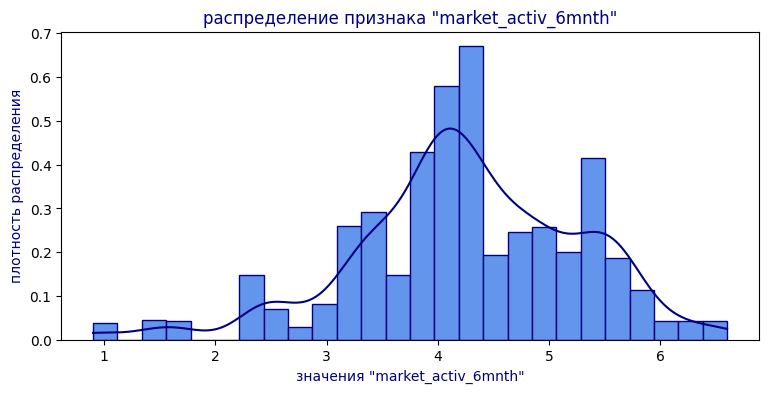

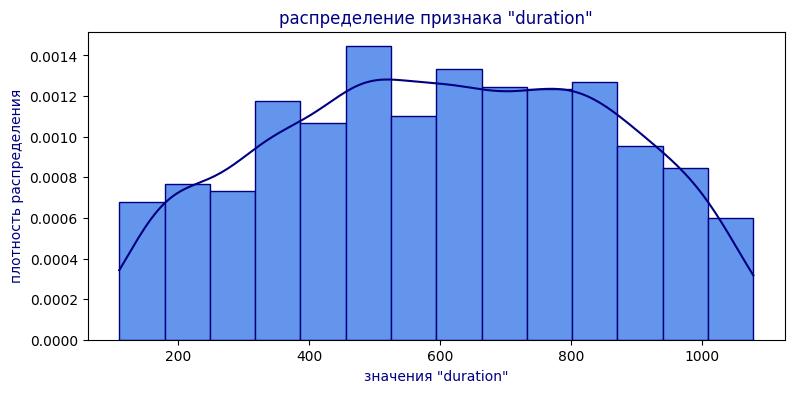

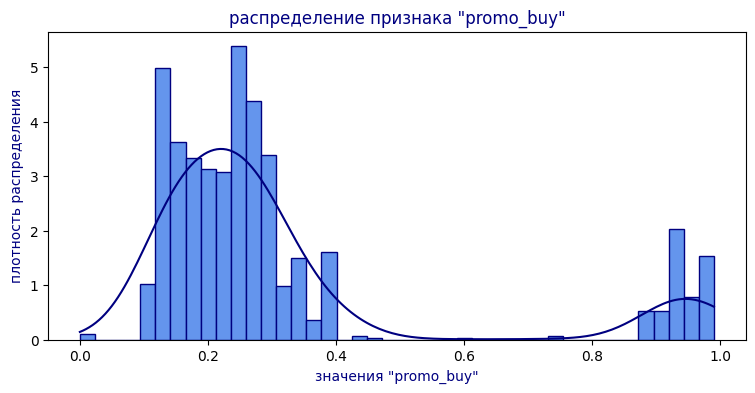

In [101]:
continuous_num_cols = ['market_activ_6mnth', 'duration', 'promo_buy']
for column in continuous_num_cols:
    continuous_num_feature_plot(market_file, column)

In [102]:
def descrete_num_feature_plot(df, column):
    plt.title(f'распределение признака "{column}"', color = 'navy')
    sns.countplot(x = column, data=df, \
                  palette ={'Снизилась': 'royalblue', 'Прежний уровень': 'cornflowerblue'}, 
                  hue='buying_activ', stat="percent")
    plt.xlabel(f'количество "{column}"', color = 'navy')
    plt.xticks(rotation=45, color='navy', fontsize=7)
    plt.ylabel('процент покупателей', color = 'navy')
    plt.legend(fontsize = 8, \
               bbox_to_anchor= (1, 1), \
               title="покупательская \nактивность", \
               title_fontsize = 9)
    plt.show()

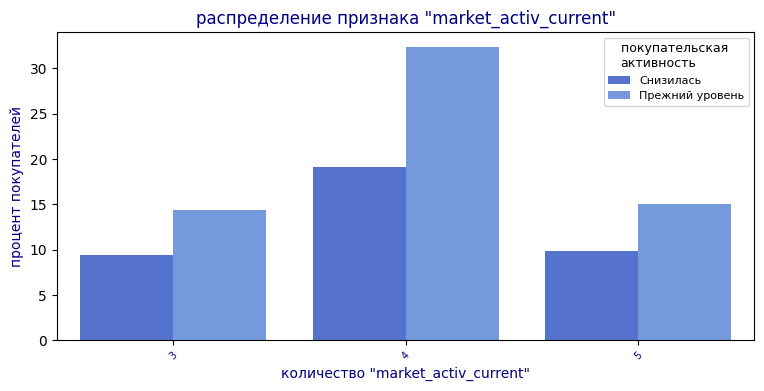

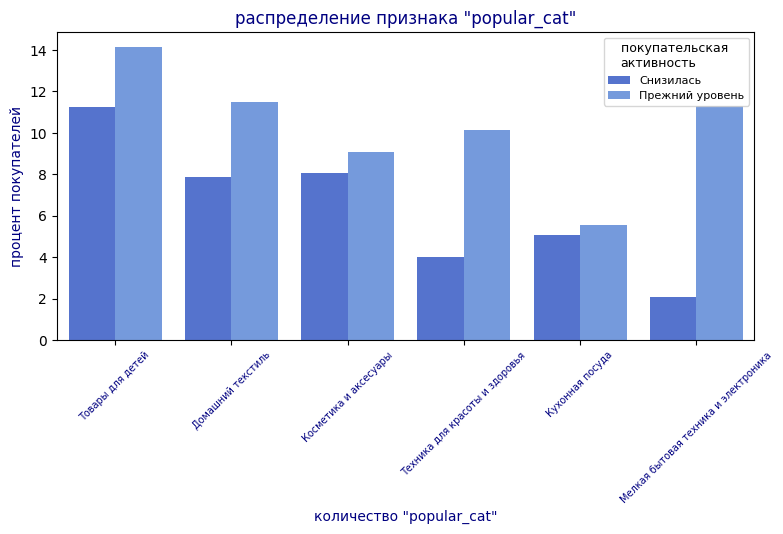

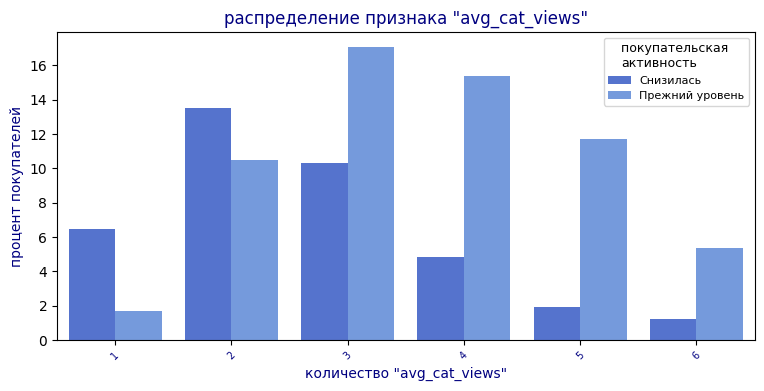

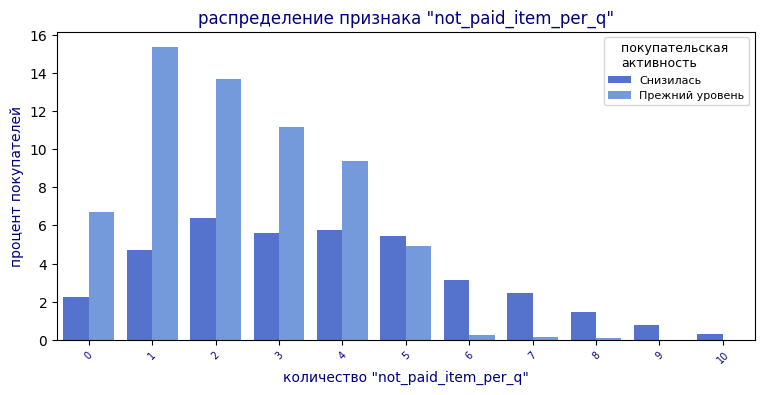

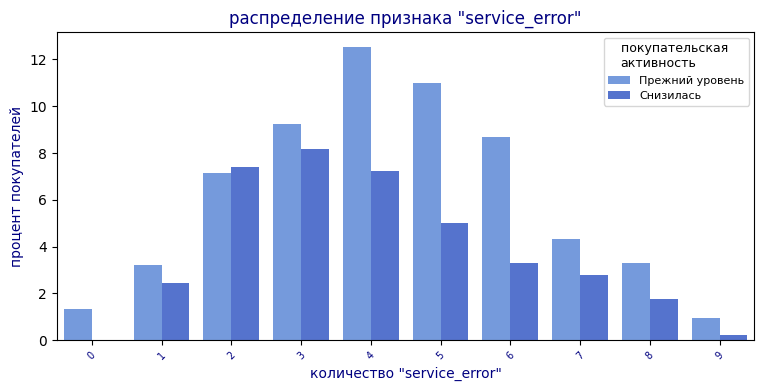

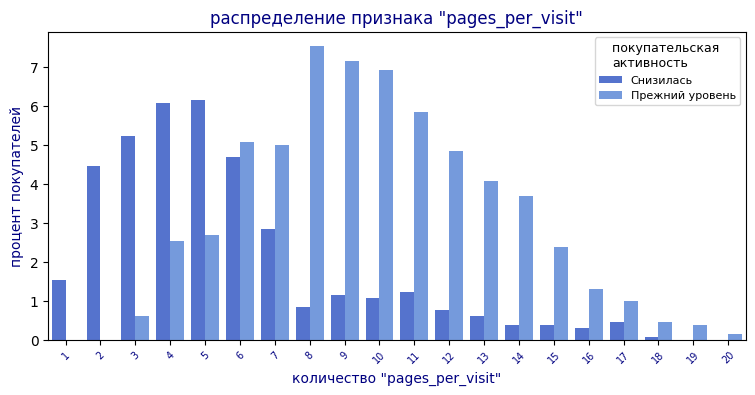

In [103]:
descret_num_cols = ['market_activ_current', 'popular_cat', 'avg_cat_views',\
                    'not_paid_item_per_q', 'service_error', 'pages_per_visit']
for column in descret_num_cols:
    plt.figure(figsize=(9,4))
    descrete_num_feature_plot(market_file, column)

In [104]:
print('Количество данных похожих на аномальные по длительности', market_file.query('duration > 1000')['id'].count())
print('Количество данных похожих на аномальные по неоплаченным покупкам', market_file.query('not_paid_item_per_q > 8')['id'].count())
print('Количество данных похожих на аномальные по количеству страниц за визит', market_file.query('pages_per_visit > 18')['id'].count())

Количество данных похожих на аномальные по длительности 62
Количество данных похожих на аномальные по неоплаченным покупкам 14
Количество данных похожих на аномальные по количеству страниц за визит 7


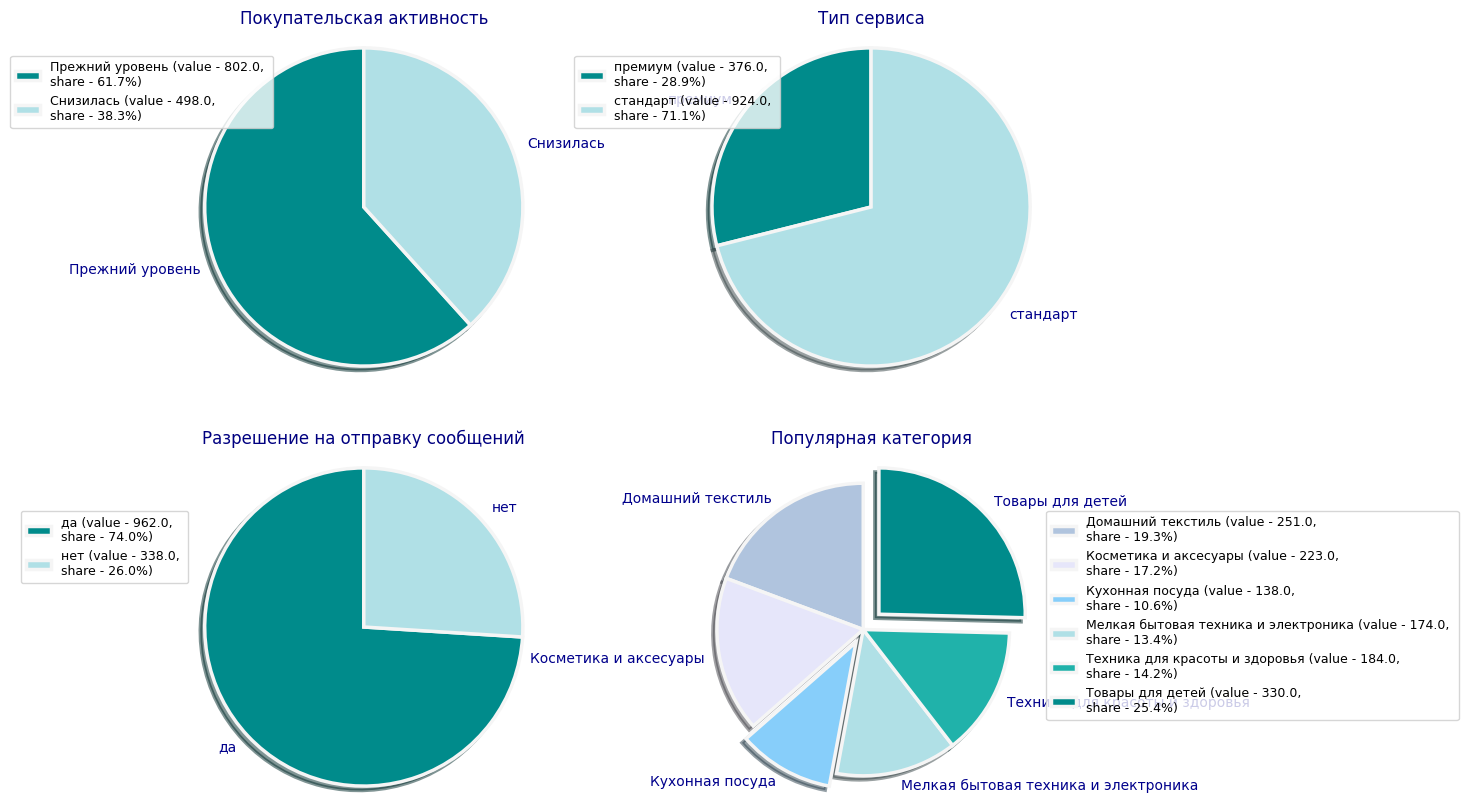

In [105]:
plt.figure(figsize=(12, 10))

#покупательская активность
buying_activ = market_file.groupby('buying_activ', as_index=False).agg({'id':'count'})
ax1 = plt.subplot(2, 2, 1)
labels = list(buying_activ['buying_activ'])
values = buying_activ['id']
total = sum(values)
colors = ['darkcyan', 'powderblue']
plt.pie(values, colors=colors, labels=labels, \
        wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
labels = [f"{n} (value - {v:.1f}, \nshare - {v/total:.1%})" for n,v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0.1, 0.6, 0.2, 0.35),
                loc = 'best', labels = labels, fontsize=9)
plt.title('Покупательская активность', color='navy')
plt.axis('equal')

#тип сервиса - service_type
service_type = market_file.groupby('service_type', as_index=False).agg({'id':'count'})
ax2 = plt.subplot(2, 2, 2)
labels = list(service_type['service_type'])
values = service_type['id']
total = sum(values)
colors = ['darkcyan', 'powderblue']
plt.pie(values, colors=colors, labels=labels, \
        wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
labels = [f"{n} (value - {v:.1f}, \nshare - {v/total:.1%})" for n,v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0.1, 0.6, 0.2, 0.35),
                loc = 'best', labels = labels, fontsize=9)
plt.title('Тип сервиса', color='navy')
plt.axis('equal')

#разрешение на сообщения allow_message
allow_message = market_file.groupby('allow_message', as_index=False).agg({'id':'count'})
ax3 = plt.subplot(2, 2, 3)
labels = list(allow_message['allow_message'])
values = allow_message['id']
total = sum(values)
colors = ['darkcyan', 'powderblue']
plt.pie(values, colors=colors, labels=labels, \
       wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
labels = [f"{n} (value - {v:.1f}, \nshare - {v/total:.1%})" for n,v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0.1, 0.5, 0, 0.35),
                loc = 'best', labels = labels, fontsize=9)
plt.title('Разрешение на отправку сообщений', color='navy')
plt.axis('equal')

#популярная категория - popular_cat
popular_cat = market_file.groupby('popular_cat', as_index=False).agg({'id':'count'})
ax4 = plt.subplot(2, 2, 4)
labels = list(popular_cat['popular_cat'])
values = popular_cat['id']
total = sum(values)
colors = ['lightsteelblue', 'lavender', 'lightskyblue', 'powderblue', 'lightseagreen', 'darkcyan']
explode = [0,0,0.1,0,0,0.15]
plt.pie(values, colors=colors, labels=labels, explode=explode, \
        wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
labels = [f"{n} (value - {v:.1f}, \nshare - {v/total:.1%})" for n,v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0.9, 0.45, 0.1, 0.4),
                loc = 'best', labels = labels, fontsize=9)
plt.title('Популярная категория', color='navy')
plt.axis('equal')

plt.show()

### Анализ данных о выручке магазина от покупателя

In [106]:
market_money.drop('id', axis=1).describe(percentiles=[.125, .5, .875])

,revenue
count,"3,900.00"
mean,"5,025.70"
std,"1,777.70"
min,0.00
12.5%,"4,353.95"
50%,"4,957.50"
87.5%,"5,755.12"
max,"106,862.20"


In [107]:
market_money.query('revenue >= 10000')

,id,period,revenue
98,215380,текущий_месяц,"106,862.20"


In [108]:
market_money.query('id == 215380')

,id,period,revenue
96,215380,препредыдущий_месяц,"5,051.00"
97,215380,предыдущий_месяц,"6,077.00"
98,215380,текущий_месяц,"106,862.20"


In [109]:
market_money = market_money.query('revenue <= 10000')
print('После удаления аномального значения выручки \nмаксимальная сумма выручки за месяц от одного покупателя составляет - ', market_money['revenue'].max())

После удаления аномального значения выручки 
максимальная сумма выручки за месяц от одного покупателя составляет -  7799.4


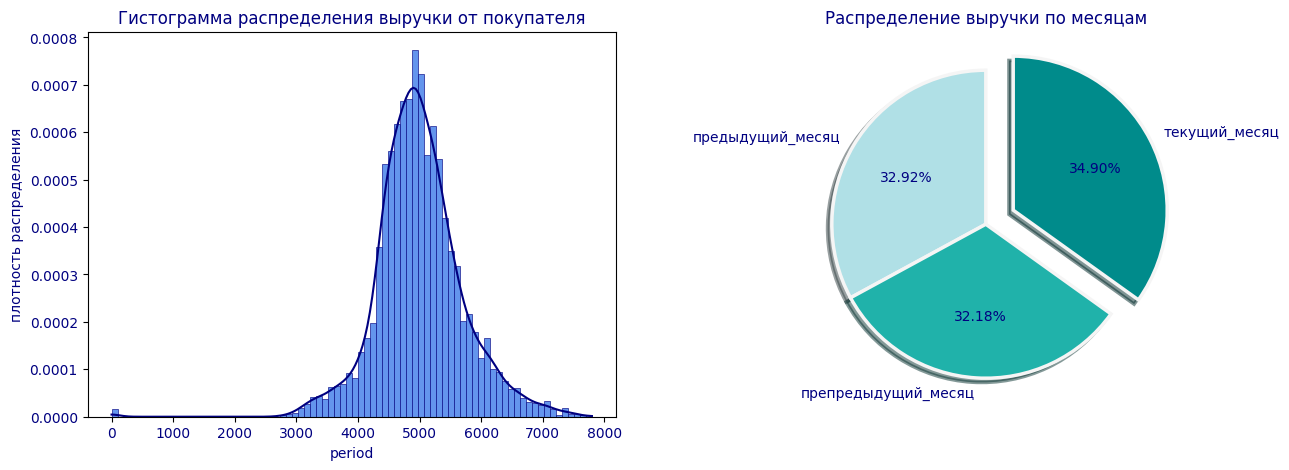

In [110]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=market_money, x='revenue', facecolor = 'cornflowerblue', \
                 edgecolor = 'navy', color='navy',\
                 stat='density', common_norm=False, kde=True)
plt.title('Гистограмма распределения выручки от покупателя',  fontsize=12, color='navy')
plt.xlabel(col, fontsize=10, color='navy')
plt.ylabel('плотность распределения', fontsize=10, color='navy')
plt.yticks(fontsize=10, color='navy')
plt.xticks(fontsize=10, color='navy')

plt.subplot(1, 2, 2)
period = market_money.groupby('period', as_index=False).agg({'revenue':'sum'})
labels = list(period['period'])
values = period['revenue']
colors = ['powderblue', 'lightseagreen', 'darkcyan']
explode=[0,0,0.2]
plt.pie(values, colors=colors, labels=labels, explode=explode, \
            wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, autopct='%1.2f%%', startangle=90, \
            textprops={'fontsize': 10, 'color': 'navy'})
plt.title('Распределение выручки по месяцам', fontdict = {'fontsize': 12, 'color':'navy'})
plt.show()

<font color='white'><i>Отберем клиентов с покупательской активностью не менее трёх месяцев

In [111]:
#выберем тех, кто в один из трех последних месяцев не осуществлял покупки
zero_client = market_money.query('revenue == 0')['id'].unique()
print('За последние три месяца сниженная покупательская активность выявлена у {} клиентов, \nсо следующими id:'.format(len(zero_client)), *zero_client, sep=", ")

За последние три месяца сниженная покупательская активность выявлена у 3 клиентов, 
со следующими id:, 215348, 215357, 215359


In [112]:
# исключим клиентов со нулевой покупательской активностью из всех датасетов
market_file = market_file.query('id not in @zero_client')
print('Размер датафрейма market_file', market_file.shape)
market_money = market_money.query('id not in @zero_client')
print('Размер датафрейма market_money', market_money.shape)
market_time =  market_time.query('id not in @zero_client')
print('Размер датафрейма market_time', market_time.shape)
money = money.query('id not in @zero_client')
print('Размер датафрейма market_file', money.shape)

Размер датафрейма market_file (1297, 13)
Размер датафрейма market_money (3890, 3)
Размер датафрейма market_time (2594, 3)
Размер датафрейма market_file (1297, 2)


### Анализ данных о времени, проведенном покупателем на сайте магазина

In [113]:
market_time.drop('id', axis=1).describe(percentiles=[.125, .5, .875])

,minutes
count,"2,594.00"
mean,13.34
std,4.08
min,4.00
12.5%,9.00
50%,13.00
87.5%,19.00
max,23.00


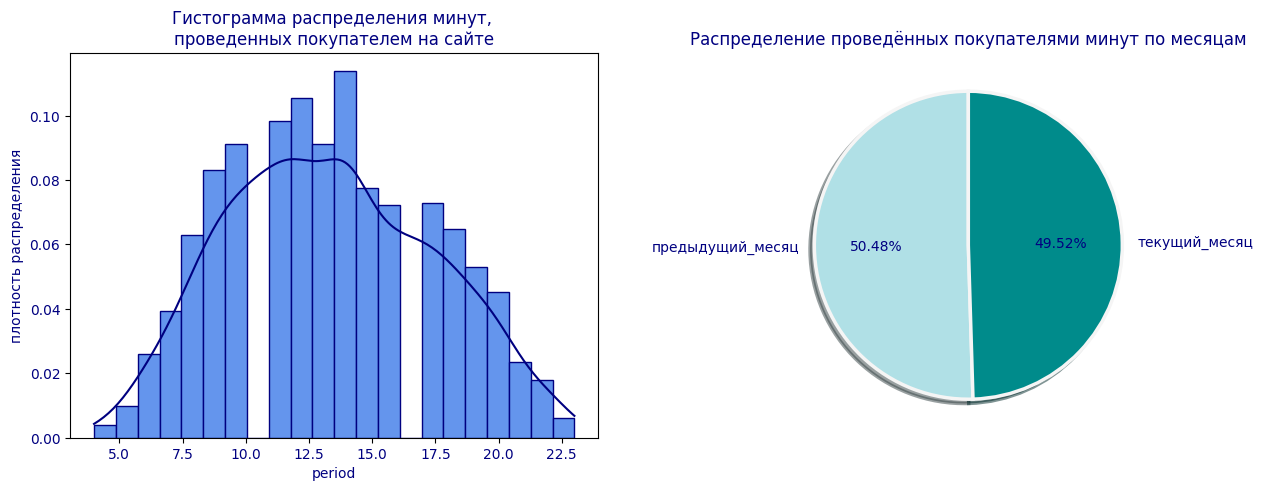

In [114]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=market_time, x='minutes', facecolor = 'cornflowerblue', \
                 edgecolor = 'navy', color='navy',\
                 stat='density', common_norm=False, kde=True)
plt.title('Гистограмма распределения минут, \nпроведенных покупателем на сайте',  fontsize=12, color='navy')
plt.xlabel(col, fontsize=10, color='navy')
plt.ylabel('плотность распределения', fontsize=10, color='navy')
plt.yticks(fontsize=10, color='navy')
plt.xticks(fontsize=10, color='navy')

plt.subplot(1, 2, 2)
period = market_time.groupby('period', as_index=False).agg({'minutes':'sum'})
labels = list(period['period'])
values = period['minutes']
colors = ['powderblue', 'darkcyan']
explode=[0,0]
plt.pie(values, colors=colors, labels=labels, explode=explode, \
            wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, autopct='%1.2f%%', startangle=90, \
            textprops={'fontsize': 10, 'color': 'navy'})
plt.title('Распределение проведённых покупателями минут по месяцам', fontdict = {'fontsize': 12, 'color':'navy'})
plt.show()


<font color='white'><b><i>Комментарий

### Анализ данных о среднемесячной прибыли от покупателя за последние 3 месяца 

In [115]:
money.drop('id', axis=1).describe(percentiles=[.125, .5, .875])

,profit
count,"1,297.00"
mean,4.00
std,1.01
min,0.86
12.5%,2.84
50%,4.04
87.5%,5.13
max,7.43


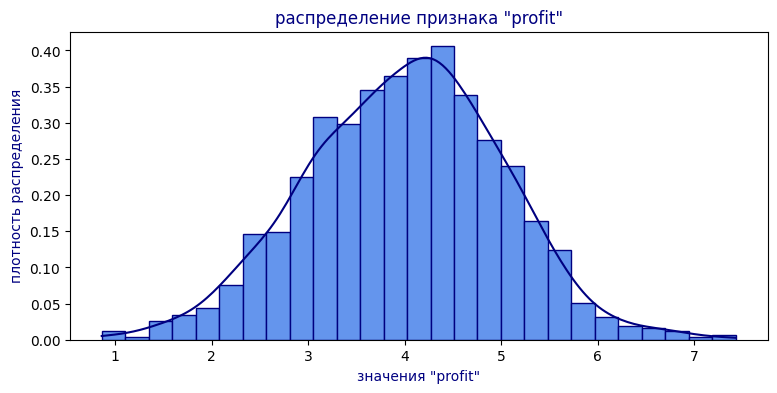

In [116]:
continuous_num_feature_plot(money, 'profit')

### Объединение данных

#### Объединение данных о поведении покупателей и выручке, которую они приносят магазину

In [117]:
periods = ['текущий_месяц', 'предыдущий_месяц','препредыдущий_месяц']
for month in periods:
    market_file = market_file.merge(market_money.query('period == @month'),
                                       on='id', how='left', suffixes=('_a', '_b'))
market_file.head()

,id,buying_activ,service_type,allow_message,market_activ_6mnth,market_activ_current,duration,promo_buy,popular_cat,avg_cat_views,not_paid_item_per_q,service_error,pages_per_visit,period_a,revenue_a,period_b,revenue_b,period,revenue
0,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,текущий_месяц,"4,971.60",предыдущий_месяц,"5,216.00",препредыдущий_месяц,"4,472.00"
1,215350,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,текущий_месяц,"5,058.40",предыдущий_месяц,"5,457.50",препредыдущий_месяц,"4,826.00"
2,215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,текущий_месяц,"6,610.40",предыдущий_месяц,"6,158.00",препредыдущий_месяц,"4,793.00"
3,215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,текущий_месяц,"5,872.50",предыдущий_месяц,"5,807.50",препредыдущий_месяц,"4,594.00"
4,215353,Снизилась,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4,текущий_месяц,"5,388.50",предыдущий_месяц,"4,738.50",препредыдущий_месяц,"5,124.00"


In [118]:
# удалим ненужные колонки с периодами и переименуем колонки с выручкой
market_file = market_file.drop(['period_a', 'period_b', 'period'], axis=1)
market_file = market_file.rename(columns={'revenue_a':'revenue_current', 'revenue_b':'revenue_pre', 'revenue':'revenue_prepre'})
# проверим корректность присоедининения таблиц и переименования столбцов
print(market_file.query('id == 215349')[['id', 'revenue_current', 'revenue_pre', 'revenue_prepre']].T)
market_money.query('id == 215349')

                         0
id              215,349.00
revenue_current   4,971.60
revenue_pre       5,216.00
revenue_prepre    4,472.00


,id,period,revenue
3,215349,препредыдущий_месяц,"4,472.00"
4,215349,текущий_месяц,"4,971.60"
5,215349,предыдущий_месяц,"5,216.00"


#### Объединение данных о поведении покупателей и времни, которое покупатели проводят на сайте

In [119]:
periods_min = ['текущий_месяц', 'предыдущий_месяц']
for month in periods_min:
    market_file = market_file.merge(market_time.query('period == @month'),
                                       on='id', how='left', suffixes=('_с', '_d'))
market_file.columns.values

array(['id', 'buying_activ', 'service_type', 'allow_message',
       'market_activ_6mnth', 'market_activ_current', 'duration',
       'promo_buy', 'popular_cat', 'avg_cat_views', 'not_paid_item_per_q',
       'service_error', 'pages_per_visit', 'revenue_current',
       'revenue_pre', 'revenue_prepre', 'period_с', 'minutes_с',
       'period_d', 'minutes_d'], dtype=object)

In [120]:
# удалим ненужные колонки с периодами
market_file = market_file.drop(['period_с', 'period_d'], axis=1)
market_file = market_file.rename(columns={'minutes_с':'minutes_current', 'minutes_d':'minutes_pre'})
# проверим корректность присоедининения таблиц и переименования столбцов
print(market_file.query('id == 215349')[['id', 'minutes_current', 'minutes_pre']].T)
market_time.query('id == 215349')

                      0
id               215349
minutes_current      10
minutes_pre          12


,id,period,minutes
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12


### Анализ объединенных данных

#### Анализ распределения количественных признаков в разрезе типов активности покупателей

In [121]:
# соформируем функцию для визуализации распределения непрерывных количественных признаокв 
# в разрезе категорий целевого признака - покупательская активность
def continuous_num_feature_plot_2(df, col):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=col, hue='buying_activ', palette ={'Снизилась': 'navy', 'Прежний уровень': 'cornflowerblue'}, \
                 edgecolor = 'navy', \
                 stat='density', common_norm=False, kde=True)
    plt.title(f'Гистограмма распределения \nдля "{col}" по типам активности',  fontsize=12, color='navy')
    plt.xlabel(col, fontsize=10, color='navy')
    plt.ylabel('плотность распределения', fontsize=10, color='navy')
    plt.yticks(fontsize=10, color='navy')
    plt.xticks(fontsize=10, color='navy')

    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x='buying_activ', y=col, hue='buying_activ', 
                palette ={'Снизилась': 'lightsteelblue', 'Прежний уровень': 'cornflowerblue'}, fill=True, gap=.1, width=.75, \
                linecolor='navy')
    plt.title(f'Диаграмма размаха \nдля "{col}" по типам активности',  fontsize=12, color='navy')
    plt.ylabel(col, fontsize=10, color='navy')
    plt.xlabel('buying_activ', fontsize=10, color='navy')
    plt.yticks(fontsize=10, color='navy')
    plt.xticks(fontsize=10, color='navy')
    plt.show()

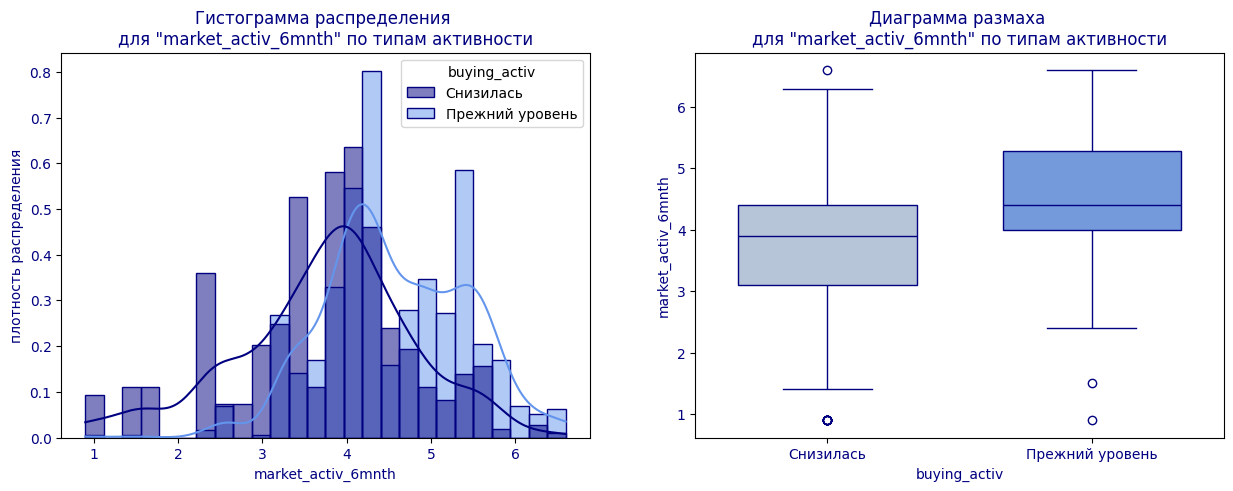

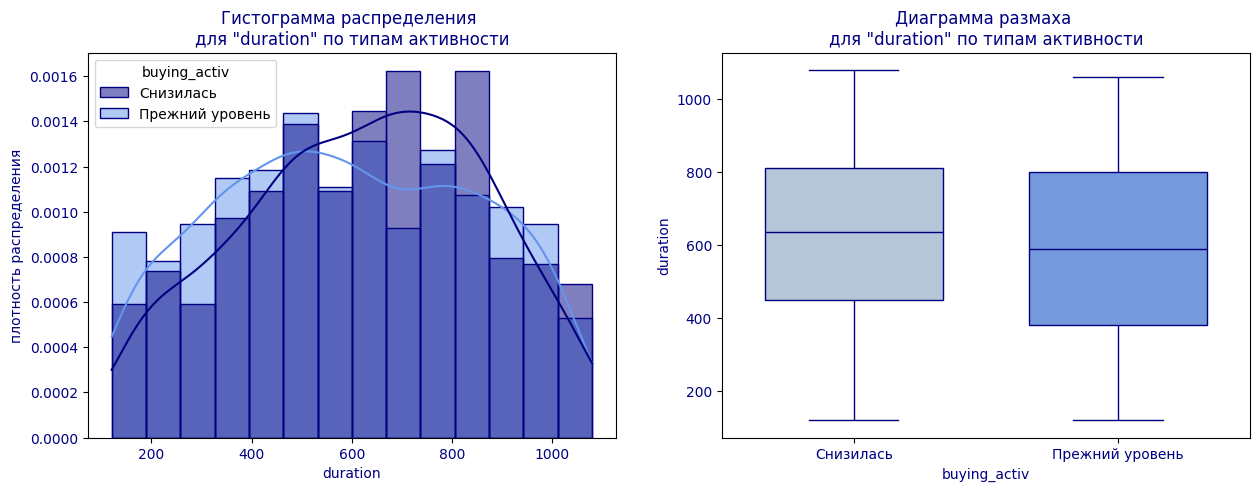

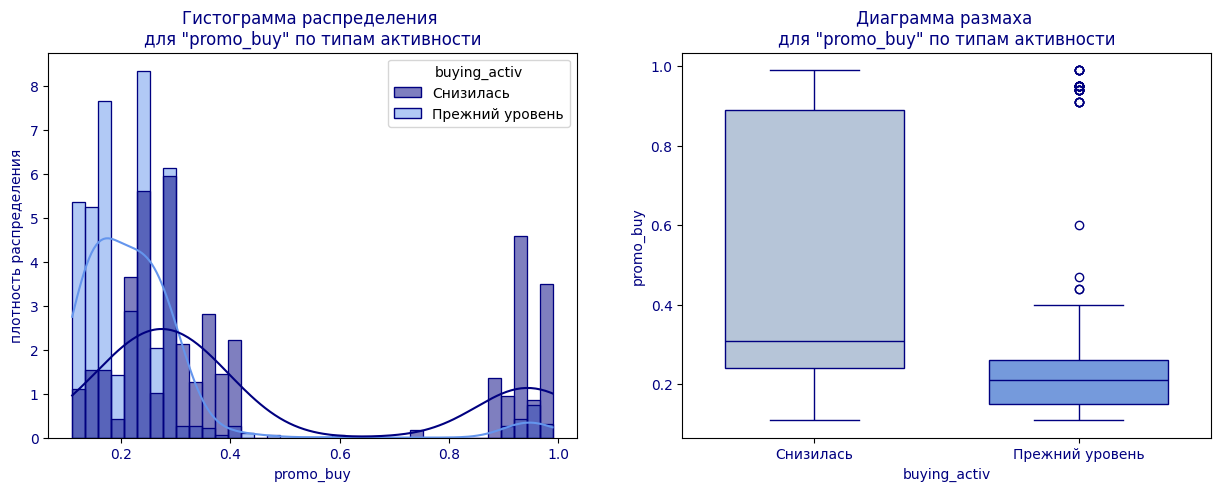

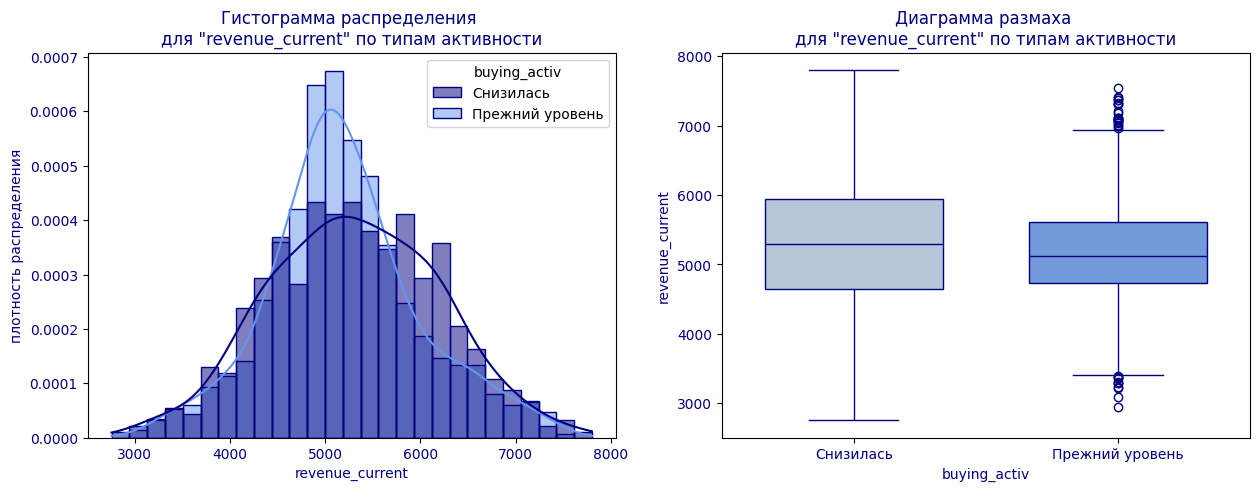

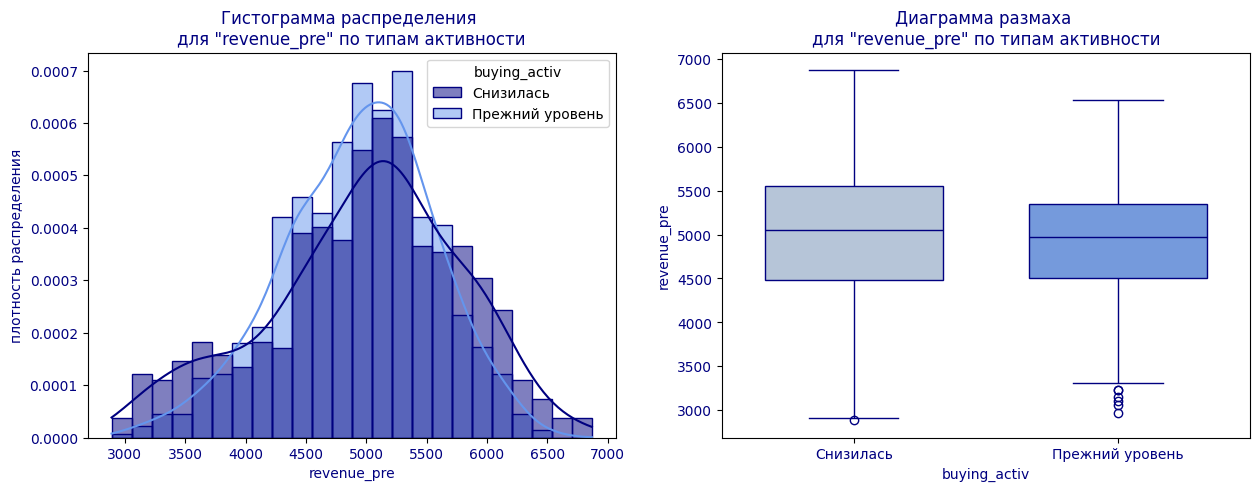

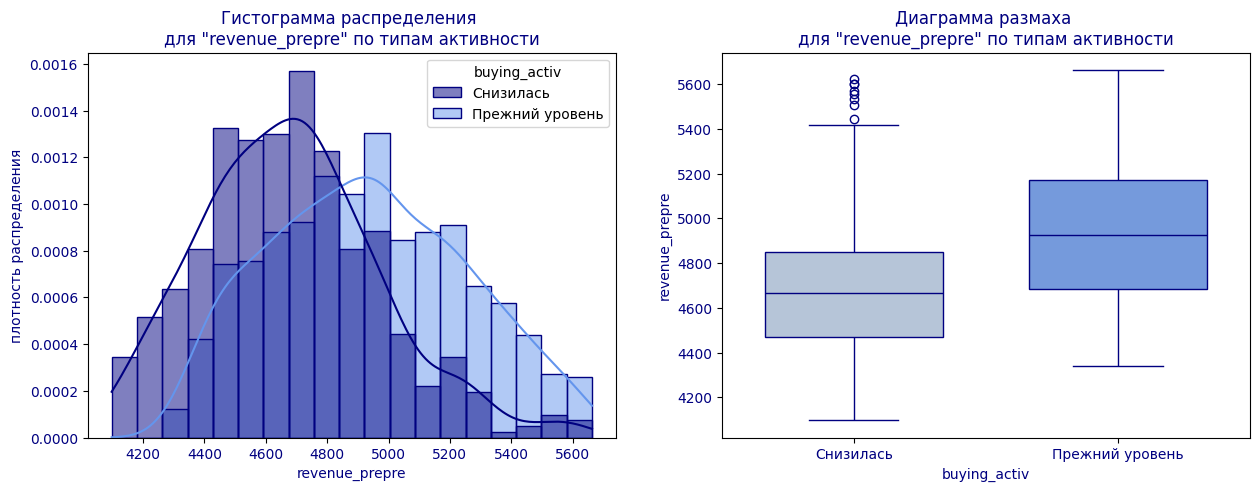

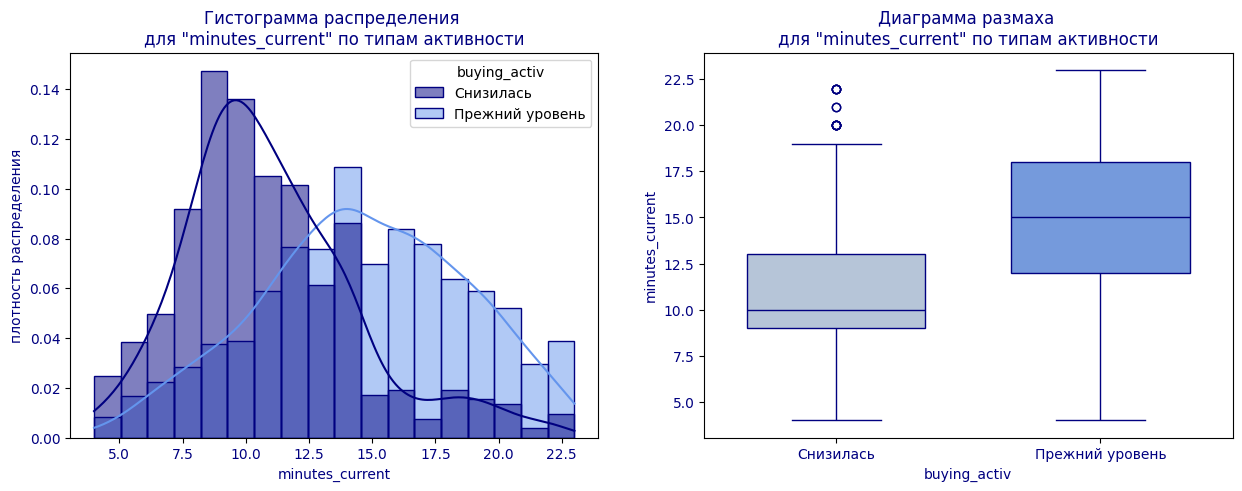

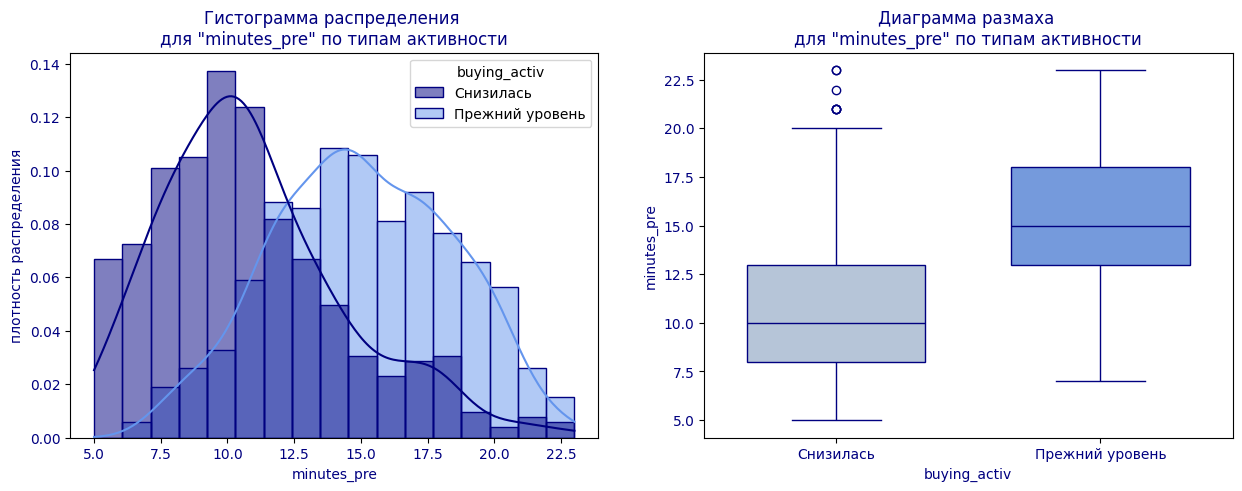

In [122]:
continuous_num_cols_2 = continuous_num_cols + \
                    ['revenue_current', 'revenue_pre', 'revenue_prepre', 'minutes_current', 'minutes_pre']
for num_col in continuous_num_cols_2:
    continuous_num_feature_plot_2(market_file, num_col)

#### Анализ распределения категорийных признаков в разрезе типов активности покупателей

In [123]:
# соформируем функцию для визуализации распределения категорийных признаокв 
# в разрезе категорий целевого признака - покупательская активность
def cat_feature_plot(df, col):
    labels = list(df[col].unique())
    values_a = df[df['buying_activ'] == 'Снизилась'].groupby(col)['id'].count()
    values_b = df[df['buying_activ'] == 'Прежний уровень'].groupby(col)['id'].count()
    total_a = sum(values_a)
    total_b = sum(values_b)
    labels_a = [f"{n} (value - {v:.1f}, \nshare - {v/total_a:.1%})" for n,v in zip(labels, values_a)]
    labels_b = [f"{n} (value - {v:.1f}, \nshare - {v/total_b:.1%})" for n,v in zip(labels, values_b)]
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.pie(values_a, colors=sns.color_palette('Blues_r'), \
        wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
    plt.title(f'Распределение "{col}" для покупателей \nсо сниженной покупательской активностью',  fontsize=12, color='navy')
    plt.legend(bbox_to_anchor = (0.9, 0.45, 0.1, 0.4),
                loc = 'best', labels = labels_a, fontsize=9)
    plt.subplot(1, 2, 2)
    plt.pie(values_b, colors=sns.color_palette('vlag'), \
        wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
    plt.title(f'Распределение "{col}" для покупателей \nс прежней покупательской активностью',  fontsize=12, color='navy')
    plt.legend(bbox_to_anchor = (0.9, 0.45, 0.1, 0.4),
                loc = 'best', labels = labels_b, fontsize=9)
    plt.show()

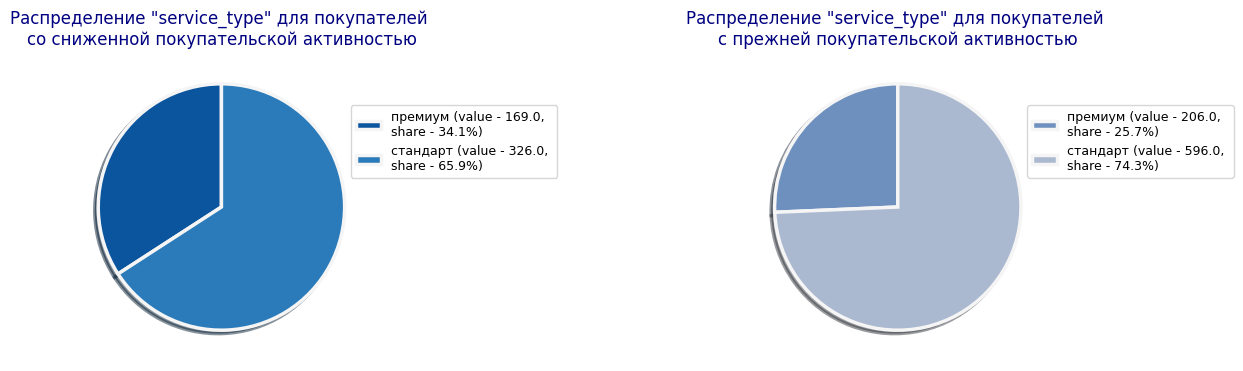

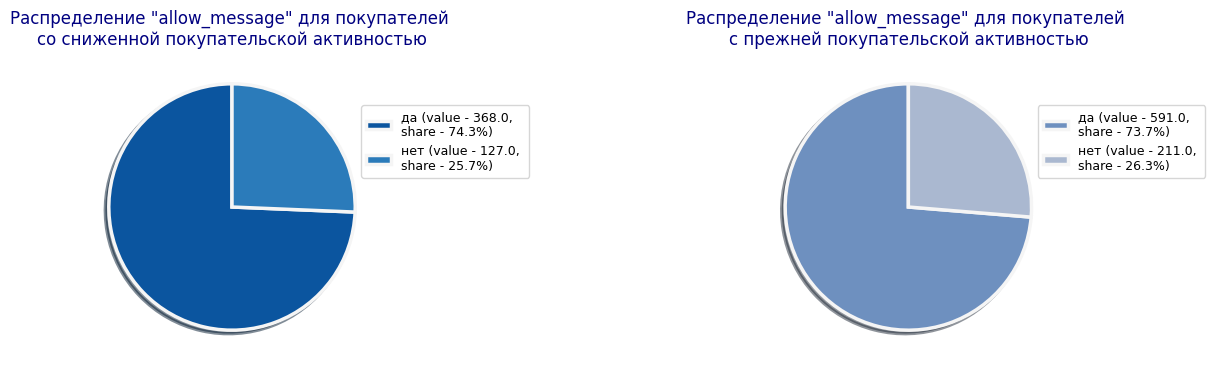

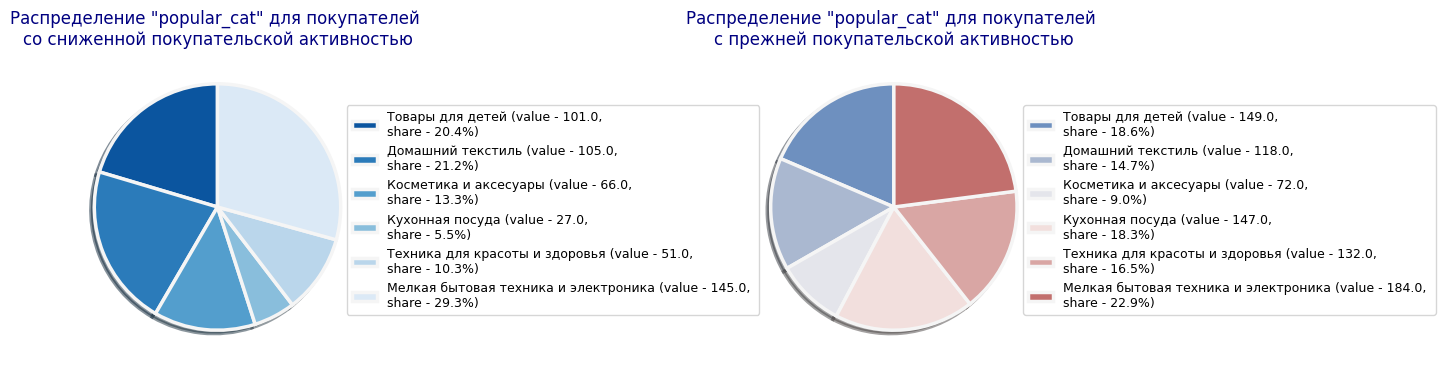

In [124]:
cat_col = market_file.drop(['id', 'buying_activ'], axis=1).select_dtypes(include='object').columns.to_list()
for cat_col in cat_col:
    cat_feature_plot(market_file, cat_col)

### Корреляционный анализ

In [125]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['market_activ_6mnth', 'promo_buy', 'avg_cat_views', \
                 'revenue_current', 'revenue_pre', 'revenue_prepre']

In [126]:
# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(market_file.drop('id', axis=1), interval_cols=interval_cols) 

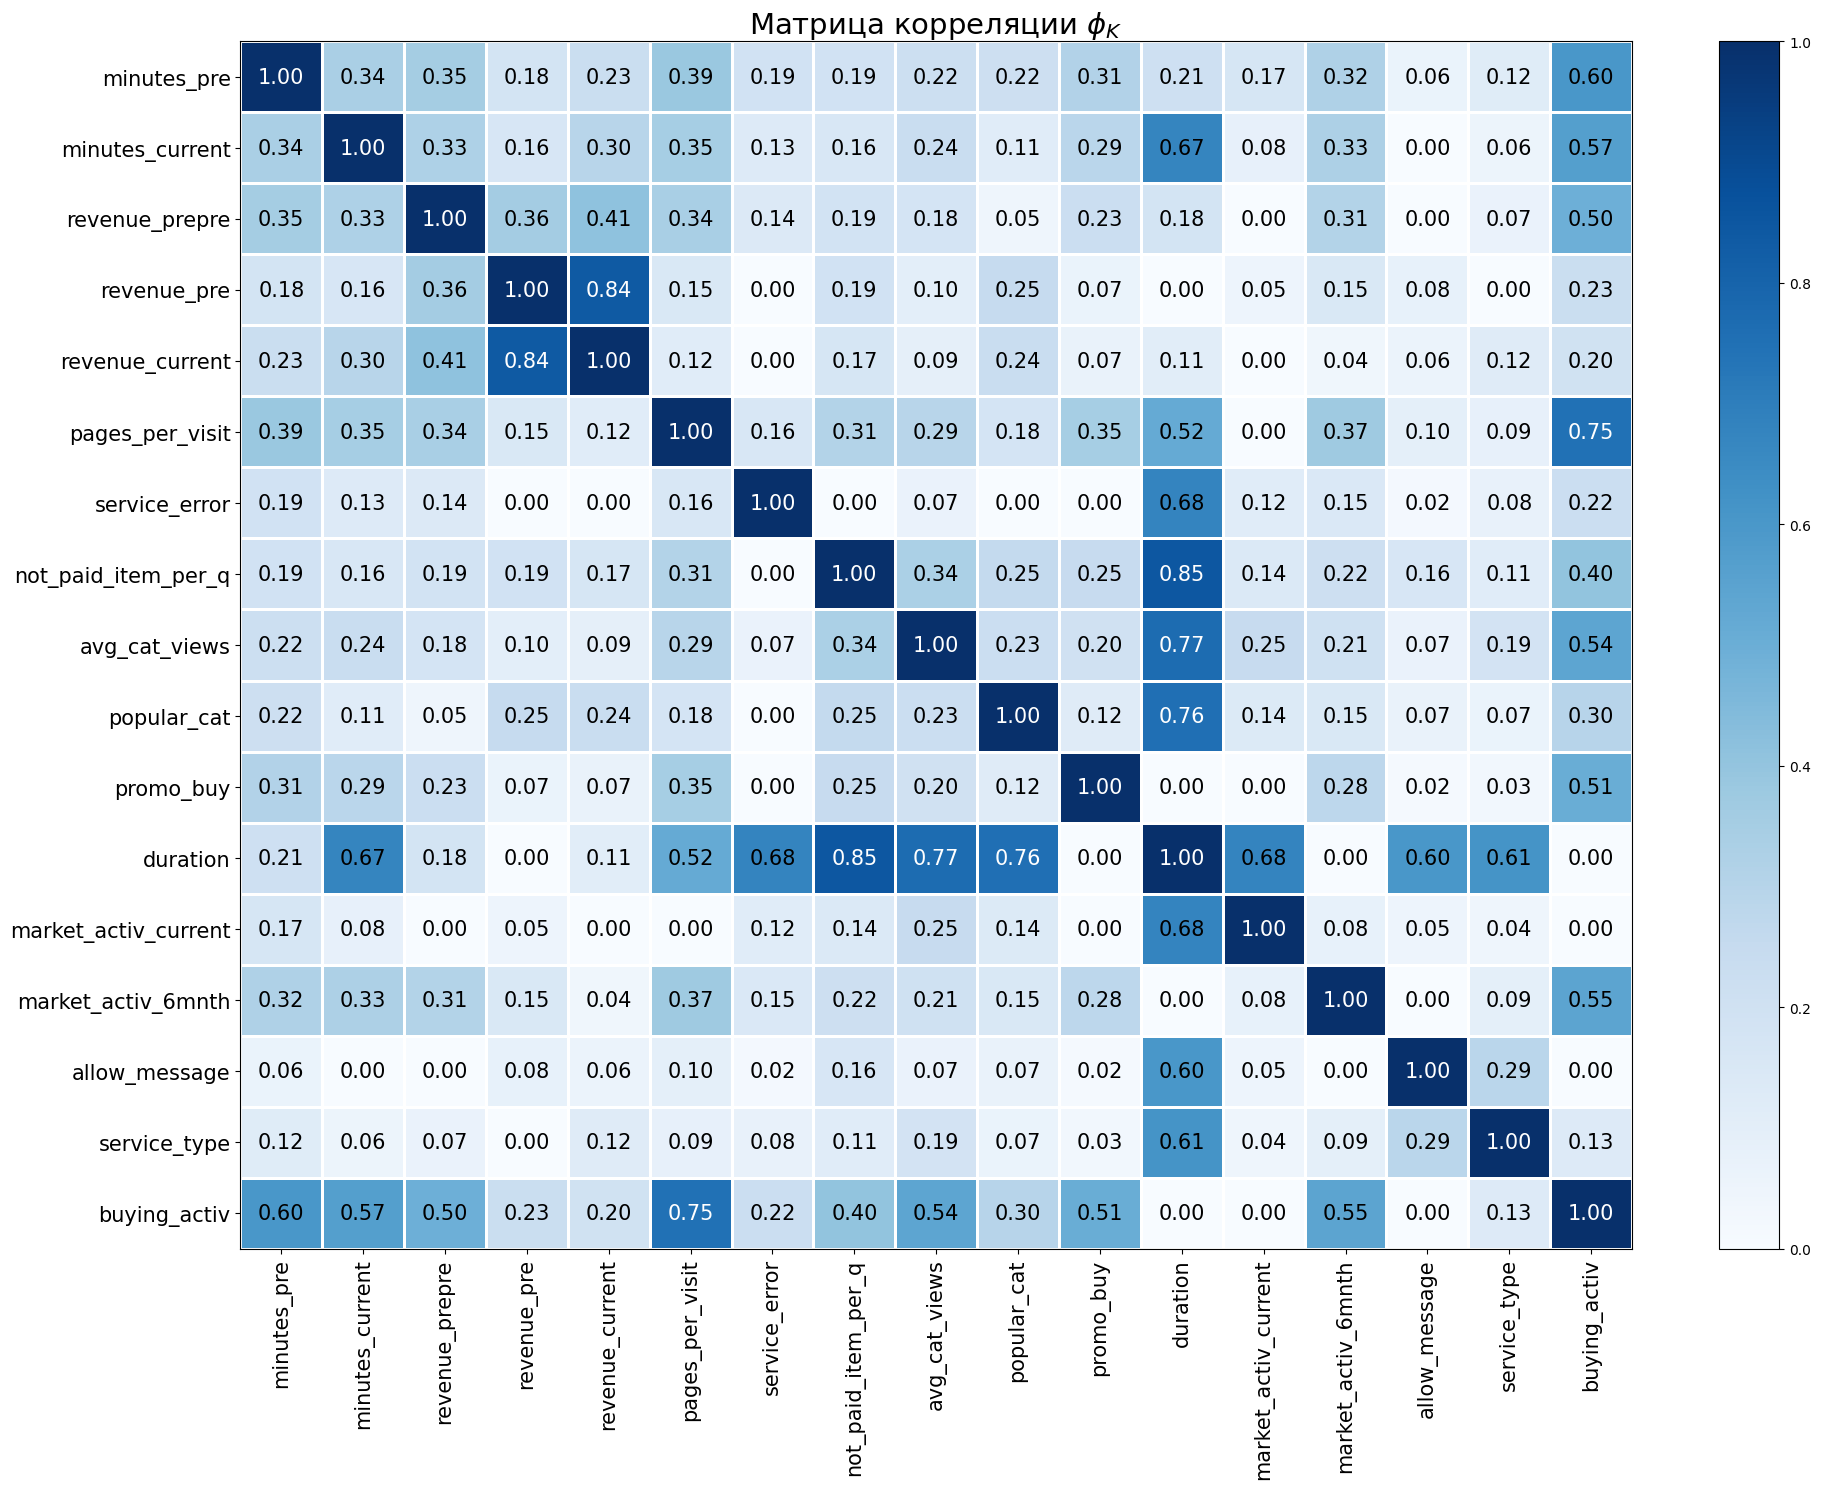

In [127]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'Матрица корреляции $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

In [128]:
market = market_file.drop(['duration','revenue_current'], axis=1)

## Определение наилучшей модели для прогноза покупательской активности

In [129]:
# изменим показатель 'promo_buy' на категориальный: все что выше порога 0.5 - 1, ниже порога - 0
market['promo_'] = market['promo_buy'].apply(lambda x : 1 if x>0.5 else 0)
market['promo_'].unique()

array([1, 0])

### Разбиение на выборки, кодирование целевого признака

In [130]:
# определяем константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

# делим данные на входные и целевые
X = market.drop(['buying_activ', 'id', 'promo_buy'], axis=1)
y = market['buying_activ']

# делим данные на тренировочные и тестовые
# используем константы с размером тестовой выборки и random_state
# выполняем стратификацию по целевому признаку
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y)

In [131]:
print('Размер тренировочной выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)
X.columns.to_list()

Размер тренировочной выборки: (972, 14)
Размер тестовой выборки: (325, 14)


['service_type',
 'allow_message',
 'market_activ_6mnth',
 'market_activ_current',
 'popular_cat',
 'avg_cat_views',
 'not_paid_item_per_q',
 'service_error',
 'pages_per_visit',
 'revenue_pre',
 'revenue_prepre',
 'minutes_current',
 'minutes_pre',
 'promo_']

In [132]:
# создаём списки с названиями признаков для различных методов подготовки данных
ohe_columns = ['popular_cat']
ord_columns = ['service_type', 'allow_message', 'promo_']
num_columns = ['market_activ_6mnth', 'market_activ_current', 'avg_cat_views', 'not_paid_item_per_q', 
               'service_error', 'pages_per_visit', 'revenue_pre', 'revenue_prepre', 'minutes_current', 'minutes_pre']

In [133]:
# кодирование целевого признака
#создаем экземпляр класса LabelEncoder
label_encoder = LabelEncoder()
# кодируем тренировочную выборку
y_train = label_encoder.fit_transform(y_train)
# кодируем тестовую выборку
y_test = label_encoder.transform(y_test)

### Создание пайплайнов для подготовки данных, определения лучшей комбинации модели и гиперпараметров

In [134]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
#SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [135]:
# создаем параметры для перебора методов подготовки данных и поиска оптимальной модели 
param_grid = {
    #зададим варианты масштабирования для GridSearchCV
    'preprocessor__num': [
        StandardScaler(), 
        MinMaxScaler(), 
        RobustScaler(), 
        'passthrough'
    ],
    # зададим варианты моделей
    'models': [DecisionTreeClassifier(random_state=RANDOM_STATE), 
               KNeighborsClassifier(), 
               SVC(random_state=RANDOM_STATE, probability=True), 
               LogisticRegression(random_state=RANDOM_STATE)]
}

### Обучение и выбор наилучшей модели

#### Выбор наилучшей модели путем перебора методов масштабирования и типов моделей

In [136]:
# для подбора гиперпараметров будем использовать инструмент GridSearchCV, в ктором 
# в качестве модели укажем финальный пайплайн
# в качестве гиперпараметров словарь гиперпараметров с методами подготовки данных и поиска оптимальной модели
# в качестве метрики модели - roc-auc
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5,
    scoring='roc_auc', 
    n_jobs=-1
)
# обучим модель и посмотрим метрику на тренировочной выборке
grid.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print('Метрика ROC-AUC для лучшей модели:', round(grid.best_score_, 4))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['popular_cat']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                    

In [137]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

dummy_clf.predict(X_train)
dummy_clf_probas = dummy_clf.predict_proba(X_test)[:,1]

# Рассчитываем и выводим метрику ROC-AUC
dummy_roc_auc = roc_auc_score(y_test, dummy_clf_probas)
print('Метрика ROC-AUC для константной модели:', round(dummy_roc_auc, 4))

Метрика ROC-AUC для константной модели: 0.5


#### Выбор наилучшей модели путем перебора моделей, их гиперпараметров и методов подготовки данных

In [138]:
param_distributions = [
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },]

In [139]:
# для подбора гиперпараметров будем использовать инструмент RindomizedSearchCV, в котором 
# в качестве модели укажем финальный пайплайн
# в качестве гиперпараметров моделей словарей гиперпараметров моделей 
# в качестве метрики модели - roc-auc
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring = 'roc_auc', 
    random_state=RANDOM_STATE, 
    n_jobs=-1
)

# обучим модель и посмотрим метрику на тренировочной выборке
randomized_search.fit(X_train, y_train) 

print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('\n\nМетрика ROC-AUC для лучшей модели:', round(randomized_search.best_score_, 4)) 

# посмотрим метрику лучшей модели на тестовой выборке
#y_test_pred_proba = grid.predict_proba(X_test)[:, 1]
#print('\nМетрика ROC-AUC на тестовой выборке', round(roc_auc_score(y_test, y_test_pred_proba), 4))

C:\Users\Arina_Luzgina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['popular_cat']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                   

In [140]:
print('Посморим параметры лучшей модели, определенной поиском GridSearchCV с перебором моделей и методов масштабирования')
print(grid.best_params_,'\nМетрика ROC_AUC на тренировочной выборке -', round(grid.best_score_, 4)) 

Посморим параметры лучшей модели, определенной поиском GridSearchCV с перебором моделей и методов масштабирования
{'models': SVC(probability=True, random_state=42), 'preprocessor__num': StandardScaler()} 
Метрика ROC_AUC на тренировочной выборке - 0.9137


In [141]:
print('Посморим параметры лучшей модели, определенной поиском RandomizedSearchCV \nс перебором методов маштабирования, моделей и их гиперпараметров')
print(randomized_search.best_params_,'\nМетрика ROC_AUC на тренировочной выборке -', round(randomized_search.best_score_, 4)) 

Посморим параметры лучшей модели, определенной поиском RandomizedSearchCV 
с перебором методов маштабирования, моделей и их гиперпараметров
{'preprocessor__num': StandardScaler(), 'models': SVC(probability=True, random_state=42)} 
Метрика ROC_AUC на тренировочной выборке - 0.9137


<font color='white'><i><b>Оба подбора дали идентичный результат. Оценим ROC-AUC на лучшей модели для тестовых данных

In [142]:
# посмотрим метрику лучшей модели на тестовой выборке
y_test_pred_proba = grid.predict_proba(X_test)[:, 1]
print('Метрика ROC-AUC на тестовой выборке:', round(roc_auc_score(y_test, y_test_pred_proba), 4))

Метрика ROC-AUC на тестовой выборке: 0.9134


### Резюме

In [ ]:
#кодируем признаки выбранным наиболее подходящим кодировщиком
X_coded = grid.best_estimator_['preprocessor'].fit_transform(X_train)
# обучаем определенную как лучшая модель на закодированных входных признаках
model = grid.best_estimator_['models'].fit(X_coded, y_train)
# формируем список признаков
features_names = grid.best_estimator_[:-1].get_feature_names_out()
# сформируем новый датафрейм с закодированными данными тренировочной выборки
X_train_coded = pd.DataFrame(X_coded, columns = features_names)

In [ ]:
background = shap.maskers.Independent(X_coded, max_samples=50)

explainer = shap.Explainer(grid.best_estimator_['models'].predict, background, feature_names=features_names)
explanation = explainer(X_coded)

PermutationExplainer explainer: 973it [17:31,  1.10s/it]                         


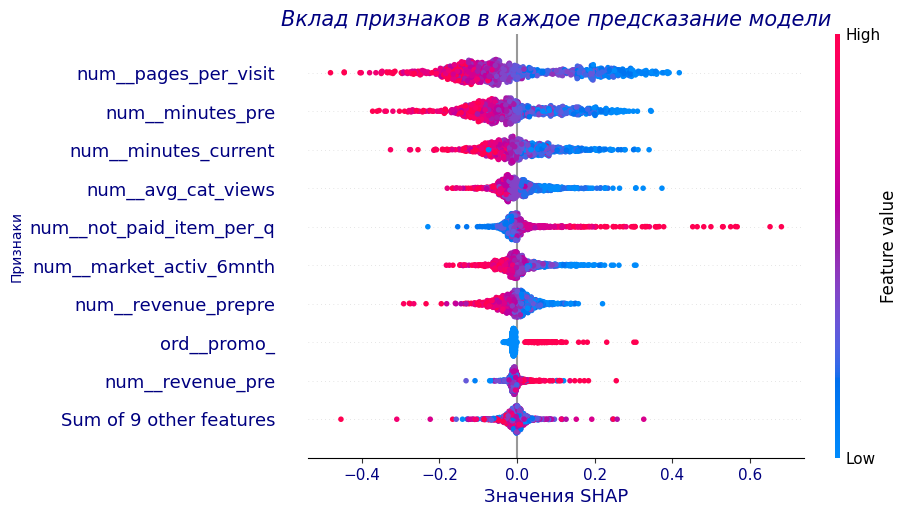

In [ ]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 1, 1)
shap.plots.beeswarm(explanation, show=False)
plt.title('Вклад признаков в каждое предсказание модели', color='navy', fontsize = 15, fontstyle='italic')
plt.ylabel('Признаки', color = 'navy')
plt.yticks(color = 'navy')
plt.xticks(color = 'navy')
plt.xlabel('Значения SHAP', color = 'navy')
plt.show()

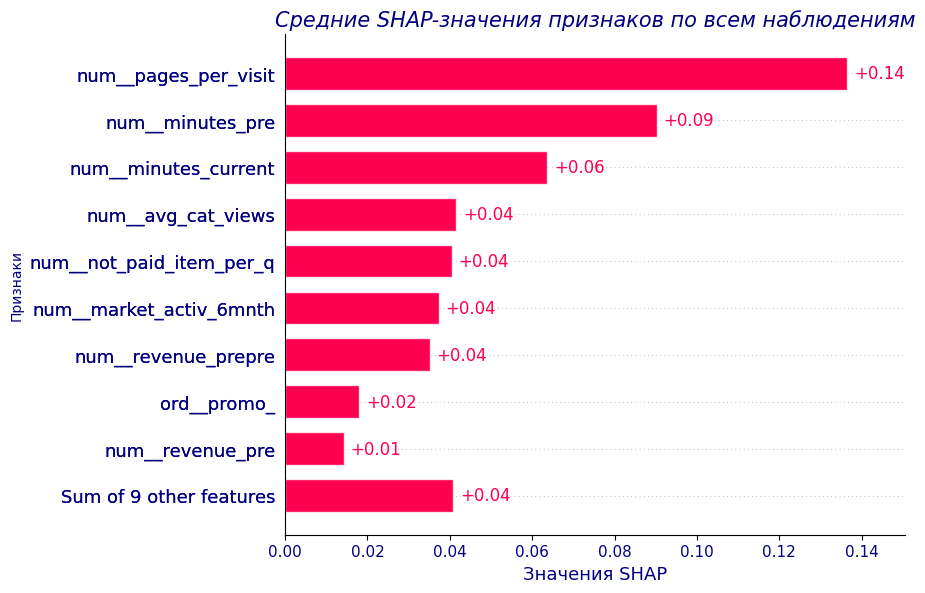

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)
shap.plots.bar(explanation, show=False)
plt.title('Средние SHAP-значения признаков по всем наблюдениям', color='navy', fontsize = 15, fontstyle='italic')
plt.ylabel('Признаки', color = 'navy')
plt.yticks(color = 'navy')
plt.xticks(color = 'navy')
plt.xlabel('Значения SHAP', color = 'navy')
plt.show()